In [1]:
import torch

# ============================================================
# Dataset Building for Character-Level Language Model
# ============================================================
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
import torch
import numpy as np
from torch import Tensor

# Fix random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)



# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    print("Word: ",w)
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


Word:  emma
........ ---> e
.......e ---> m
......em ---> m
.....emm ---> a
....emma ---> .
Word:  olivia
........ ---> o
.......o ---> l
......ol ---> i
.....oli ---> v
....oliv ---> i
...olivi ---> a
..olivia ---> .
Word:  ava
........ ---> a
.......a ---> v
......av ---> a
.....ava ---> .
Word:  isabella
........ ---> i
.......i ---> s
......is ---> a
.....isa ---> b
....isab ---> e
...isabe ---> l
..isabel ---> l
.isabell ---> a
isabella ---> .
Word:  sophia
........ ---> s
.......s ---> o
......so ---> p
.....sop ---> h
....soph ---> i
...sophi ---> a
..sophia ---> .
Word:  charlotte
........ ---> c
.......c ---> h
......ch ---> a
.....cha ---> r
....char ---> l
...charl ---> o
..charlo ---> t
.charlot ---> t
charlott ---> e
harlotte ---> .
Word:  mia
........ ---> m
.......m ---> i
......mi ---> a
.....mia ---> .
Word:  amelia
........ ---> a
.......a ---> m
......am ---> e
.....ame ---> l
....amel ---> i
...ameli ---> a
..amelia ---> .
Word:  harper
........ ---> h
.......h --->

In [4]:


class LinearLayer:
    def __init__(self, f_in, f_out, bias=True) -> None:
        self.f_in = f_in
        self.f_out = f_out
        self.bias = bias


        self.w = torch.randn((self.f_in, self.f_out), requires_grad=True)
        if self.bias:
            self.b = torch.zeros(self.f_out, requires_grad=True)
        else:
            self.b = None

    def __call__(self, x):
        if self.bias:
            return x @ self.w + self.b
        else:
            return x @ self.w

    def parameters(self):
        return [self.w] if self.b is None else [self.w, self.b]
    
    def state_dict(self):
        return {'weight': self.w, 'bias': self.b} if self.bias else {'weight': self.w}
    
    def load_state_dict(self, state):
        self.w.data.copy_(state['weight'])
        if self.bias:
            self.b.data.copy_(state['bias'])


class EmbeddingLayer:
    def __init__(self, n_emb, d_emb) -> None:

        self.emb = torch.randn((n_emb, d_emb), requires_grad=True)

    def __call__(self, x):

        x = x.long()
        return self.emb[x]

    def parameters(self):
        return [self.emb]

    def state_dict(self):
        return {'embeddings': self.emb}
    
    def load_state_dict(self, state):
        self.emb.data.copy_(state['embeddings'])

class FlattenConsecutive:
    def __init__(self,n) -> None:
        self.n = n

    
    def __call__(self,x):
        i, j, k = x.shape
        x = x.view(i, j//self.n, k*self.n)
        if x.shape[1] == 1:
          x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
      return []
    
class Tanh:
  def __call__(self, x):
    return torch.tanh(x)
  def parameters(self):
    return []


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


  def state_dict(self):
      return {
          'gamma': self.gamma,
          'beta': self.beta,
          'running_mean': self.running_mean,
          'running_var': self.running_var
      }
  
  def load_state_dict(self, state):
      self.gamma.data.copy_(state['gamma'])
      self.beta.data.copy_(state['beta'])
      self.running_mean.data.copy_(state['running_mean'])
      self.running_var.data.copy_(state['running_var'])
# ----------------------
# Updated Sequential Class
# ----------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def state_dict(self):
        # Save each layer's state in a dictionary
        state = {}
        for idx, layer in enumerate(self.layers):
            # Check if the layer supports state_dict; if not, an empty dict is stored.
            if hasattr(layer, "state_dict"):
                state[f"layer_{idx}"] = layer.state_dict()
            else:
                state[f"layer_{idx}"] = {}
        return state

    def load_state_dict(self, state):
        for idx, layer in enumerate(self.layers):
            key = f"layer_{idx}"
            if key not in state:
                raise ValueError(f"Missing state for layer {idx}")
            if hasattr(layer, "load_state_dict"):
                layer.load_state_dict(state[key])
            else:
                continue
    def to(self, device):
        for layer in self.layers:
            if hasattr(layer, 'parameters'):
                for p in layer.parameters():
                    p.data = p.data.to(device)
            if isinstance(layer, BatchNorm1d):
                layer.running_mean = layer.running_mean.to(device)
                layer.running_var = layer.running_var.to(device)
        return self
    

In [5]:

# hierarchical network
n_embd = 50 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  EmbeddingLayer(vocab_size, n_embd),
  FlattenConsecutive(2), LinearLayer(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  LinearLayer(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].w *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

83937


In [6]:
print(len(p) for p in parameters)

<generator object <genexpr> at 0x00000172957A1630>


In [7]:
import torch.nn.functional as F

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.6695


  10000/ 200000: 1.8798
  20000/ 200000: 2.2192
  30000/ 200000: 1.9201
  40000/ 200000: 2.5415
  50000/ 200000: 2.0225
  60000/ 200000: 2.1623
  70000/ 200000: 2.3126
  80000/ 200000: 2.4818
  90000/ 200000: 2.2381
 100000/ 200000: 2.0171
 110000/ 200000: 1.8718
 120000/ 200000: 1.8766
 130000/ 200000: 1.6546
 140000/ 200000: 2.0306
 150000/ 200000: 2.3645
 160000/ 200000: 2.3360
 170000/ 200000: 1.8366
 180000/ 200000: 2.1617
 190000/ 200000: 1.9534


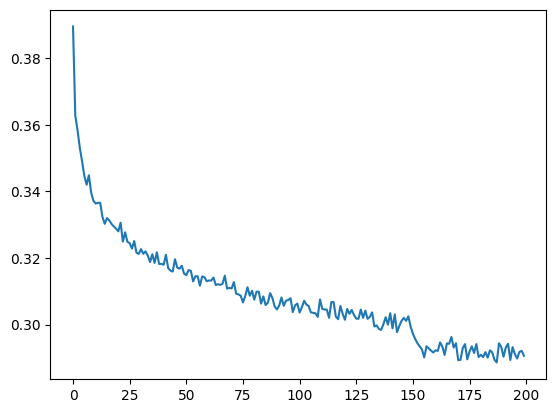

In [13]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9312348365783691
val 2.2634644508361816


In [17]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

anali.
jaylany.
majabella.
katina.
matlis.
nahwon.
brise.
karritha.
jehmir.
amer.
slannich.
joza.
bronge.
savie.
caleighe.
lerri.
michae.
moumron.
bertzive.
colmie.
